In [56]:
import json
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.circuit.library import QFT
from qiskit_ionq import IonQProvider

# Setting up the hardware

In [47]:
with open('qpu_keys.json', 'r') as keyfile:
    key = json.load(keyfile)['IonQ']

In [48]:
provider = IonQProvider(key)

In [51]:
provider.backends()
backend = provider.get_backend('ionq_qpu.aria-1')

# Circuit and Run

In [5]:
def make_circuit(eval_qubit, probability):
    eval_qubit = eval_qubit
    total_qubit = eval_qubit + 1
    
    p = probability
    theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
    theta_for_q = 2 * theta_p  # Q의 각도
    
    qreg_q = QuantumRegister(total_qubit, 'q')
    creg_c = ClassicalRegister(total_qubit-1, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    
    circuit.h(qreg_q[0:eval_qubit])
    circuit.ry(theta_p, qreg_q[eval_qubit])
    circuit.barrier()
    
    for i in range(eval_qubit):
        circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
        circuit.barrier()
    
    circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
                   qreg_q[0:eval_qubit])
    circuit.barrier()
    circuit.measure(qreg_q[0:eval_qubit], creg_c[0:eval_qubit])
    
    return circuit

In [6]:
def run_circuit(circuit, backend, shots):
    job = execute(circuit, backend=backend, shots=shots)
    result = job.result()
    
    counts = result.get_counts(circuit)
    return counts

# Viz

In [10]:
def draw_fig(eval_qubit, probability, counts, shots):
    counts = {key: value / shots for key, value in counts.items()}    
    p_tilde = [np.round(np.sin(i*np.pi/(2**eval_qubit))**2,3) for i in range(2**(eval_qubit-1)+1)]
    probs = np.zeros(2**eval_qubit, dtype=float)
    for state, value in counts.items():
        state_decimal = int(state, 2)
        probs[state_decimal] = value
        
    freqs =[]
    freqs.append(probs[0])
    i = 1
    while i < 2**eval_qubit/2:
        # print(f'These states correspond to the same bin: {i} and {2**m-i}')
        freqs.append(probs[i] + probs[2**eval_qubit-i])
        i += 1
    freqs.append(probs[2**(eval_qubit-1)])
    
    gridpoints = list(p_tilde)
    probabilities = list(freqs)
    
    fig = plt.figure()
    plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 15})
    
    plt.bar(gridpoints, probabilities, width=0.1 / len(probabilities), color='black')
    plt.axvline(probability, color="r", ls="--")
    plt.ylabel("Probability")
    plt.xlabel(r"$\tilde{p}$")
    plt.grid()
    return fig

# Run

In [52]:
eval_qubit = 3
probability = 0.3
shots = 100

circuit = make_circuit(eval_qubit=eval_qubit, probability=probability)
counts = run_circuit(circuit=circuit, backend=backend, shots=shots)

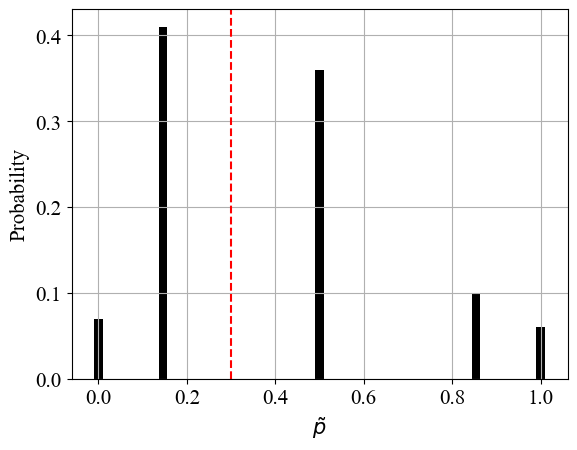

In [53]:
fig = draw_fig(eval_qubit=eval_qubit, probability=probability, 
               counts=counts, shots=shots)
# fig.savefig('figs/ideal_result.png', dpi=500)
# fig.show()

In [55]:
counts_set = defaultdict(list)
for i in range(1,20):
    eval_qubit = i
    probability = 0.2
    shots = 8192
    
    circuit = make_circuit(eval_qubit=eval_qubit, probability=probability)
    counts = run_circuit(circuit=circuit, backend=backend, shots=shots)
    counts_set[f"eval_{i}"] = counts

ReadTimeout: HTTPSConnectionPool(host='api.ionq.co', port=443): Read timed out. (read timeout=30)

In [58]:
counts_set.keys()

dict_keys(['eval_1', 'eval_2', 'eval_3', 'eval_4', 'eval_5', 'eval_6', 'eval_7', 'eval_8', 'eval_9'])

In [64]:
counts_set['eval_3']

{'001': 3518,
 '111': 3347,
 '010': 299,
 '110': 274,
 '101': 200,
 '000': 281,
 '011': 210,
 '100': 65}

In [60]:
with open('counts_set.pkl', 'wb') as f:
    pickle.dump(counts_set, f)

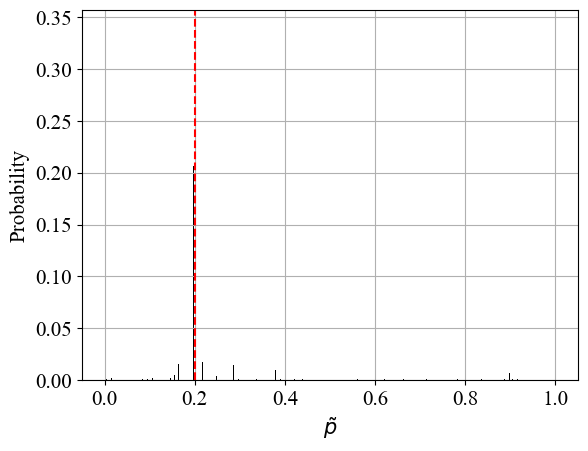

In [59]:
hmm = draw_fig(eval_qubit=9, probability=probability, counts=counts_set['eval_9'], shots=shots)

In [33]:
hmm.savefig('figs/testcase.png', dpi=500)

In [46]:
test=12
[np.round(np.sin(i*np.pi/(2**test))**2,5) for i in range(2**(test-1)+1)]

[0.0,
 0.0,
 0.0,
 1e-05,
 1e-05,
 1e-05,
 2e-05,
 3e-05,
 4e-05,
 5e-05,
 6e-05,
 7e-05,
 8e-05,
 0.0001,
 0.00012,
 0.00013,
 0.00015,
 0.00017,
 0.00019,
 0.00021,
 0.00024,
 0.00026,
 0.00028,
 0.00031,
 0.00034,
 0.00037,
 0.0004,
 0.00043,
 0.00046,
 0.00049,
 0.00053,
 0.00057,
 0.0006,
 0.00064,
 0.00068,
 0.00072,
 0.00076,
 0.00081,
 0.00085,
 0.00089,
 0.00094,
 0.00099,
 0.00104,
 0.00109,
 0.00114,
 0.00119,
 0.00124,
 0.0013,
 0.00135,
 0.00141,
 0.00147,
 0.00153,
 0.00159,
 0.00165,
 0.00171,
 0.00178,
 0.00184,
 0.00191,
 0.00198,
 0.00205,
 0.00212,
 0.00219,
 0.00226,
 0.00233,
 0.00241,
 0.00248,
 0.00256,
 0.00264,
 0.00272,
 0.0028,
 0.00288,
 0.00296,
 0.00305,
 0.00313,
 0.00322,
 0.00331,
 0.00339,
 0.00348,
 0.00357,
 0.00367,
 0.00376,
 0.00385,
 0.00395,
 0.00405,
 0.00415,
 0.00424,
 0.00434,
 0.00445,
 0.00455,
 0.00465,
 0.00476,
 0.00486,
 0.00497,
 0.00508,
 0.00519,
 0.0053,
 0.00541,
 0.00552,
 0.00564,
 0.00575,
 0.00587,
 0.00599,
 0.00611,
 0.00623